<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/Finetuning_random_seed_404.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import project files files from github 


In [1]:
# upload work files from your git hub repository
import sys

!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb

path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')

!pip3 install import_ipynb

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 712 (delta 21), reused 0 (delta 0), pack-reused 667
Receiving objects: 100% (712/712), 2.01 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (422/422), done.
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=d781d5ff4d772f7116d5fcf0dad955c32a449df0780744f43c3a7b8af98f9689
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


import libraries


In [2]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from torchvision import transforms
import numpy as np
import import_ipynb
import copy
from tqdm.notebook import tqdm
import pickle
# project classes --------------------------------------------------------------
from IncrementalLearning.cifar100 import ilCIFAR100
from IncrementalLearning.resnet_cifar import resnet32

importing Jupyter notebook from /content/IncrementalLearning/cifar100.ipynb


Extracting ./data/cifar-100-python.tar.gz to ./data
importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


Initial setup

In [3]:
# Define params

NUM_RUN = 2
SEEDS = [1,2,3]
NUM_EPOCHS = 70
BATCH_SIZE = 128
CLASSES_PER_BATCH = 10
DEVICE = 'cuda'
NUM_BATCHES=10
WEIGHT_DECAY = 1e-5
LR = 2
MOMENTUM = 0.9
MILESTONES = [49, 63]
GAMMA = 0.2
randomseed=404

Prepare dataloders for each train, val test subset of the original dataset

FINE TUNING

In [4]:
def trainmodel(model,trainloader,valloader,learningrate,weightdecay,numepochs,milestones,gamma,criterion,optimizer,scheduler,dictionary):
  model=model.to(DEVICE)
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = np.inf
  for epoch in tqdm(range(numepochs)):
    #print(epoch)
    for phase in ['train','val']:
      if phase =='train':
        model.train()
        loader = trainloader
      else:
        model.eval()
        loader = valloader
      running_loss=0.0
      running_corrects=0
      num_elements=0
      for _, inputs,labels in loader:
        labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
        num_elements+=len(inputs)
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs=model(inputs)
          labels_encoded=torch.eye(100)[labels] #CAMBIARE ONE_HOT
          labels_encoded=labels_encoded.to(DEVICE)
          _,preds=torch.max(outputs,1)
          loss=criterion(outputs,labels_encoded)
          if phase=='train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / num_elements
      epoch_acc = running_corrects.double() / num_elements
      
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model


In [5]:
original_training_set = ilCIFAR100(CLASSES_PER_BATCH,randomseed)
original_test_set = ilCIFAR100(CLASSES_PER_BATCH,randomseed, train=False)
train_indices, val_indices = original_training_set.get_train_val(0.1)
test_indices = original_test_set.get_batch_indexes()
current_test_indexes=[]
model=resnet32(num_classes=100)
diz = original_training_set.get_dict()
test_acc=[]
criterion=nn.BCEWithLogitsLoss()
for i in range(NUM_BATCHES):
  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)
  print(i)
  train_dataset=Subset(original_training_set,train_indices[i])
  val_dataset=Subset(original_training_set,val_indices[i])
  current_test_indexes+=test_indices[i].tolist()
  test_dataset=Subset(original_test_set,current_test_indexes)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
  net=trainmodel(model,train_dataloader,val_dataloader,LR,WEIGHT_DECAY,NUM_EPOCHS,MILESTONES,GAMMA,criterion,optimizer,scheduler,diz)
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  running_corrects = 0
  y_test = []
  y_pred = []
  for _, inputs, labels in test_dataloader:
      labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = net(inputs)
      _, preds = torch.max(outputs.data, 1)
      running_corrects += torch.sum(preds == labels.data).data.item()
      y_test += labels.tolist()
      y_pred += preds.tolist()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataloader.dataset))
  print('Test Accuracy: %.2f' % (100.0 * accuracy))
  print('-' * 80)
  test_acc.append(accuracy)

with open('Finetuning_'+str(randomseed)+"_testacc", 'wb') as file:
  pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)

Files already downloaded and verified
Files already downloaded and verified
0



Test Accuracy: 86.70
--------------------------------------------------------------------------------
1



Test Accuracy: 43.05
--------------------------------------------------------------------------------
2



Test Accuracy: 27.93
--------------------------------------------------------------------------------
3



Test Accuracy: 22.60
--------------------------------------------------------------------------------
4



Test Accuracy: 16.96
--------------------------------------------------------------------------------
5



Test Accuracy: 14.45
--------------------------------------------------------------------------------
6



Test Accuracy: 12.24
--------------------------------------------------------------------------------
7



Test Accuracy: 11.12
--------------------------------------------------------------------------------
8



Test Accuracy: 10.48
--------------------------------------------------------------------------------
9



Test Accuracy: 8.94
--------------------------------------------------------------------------------


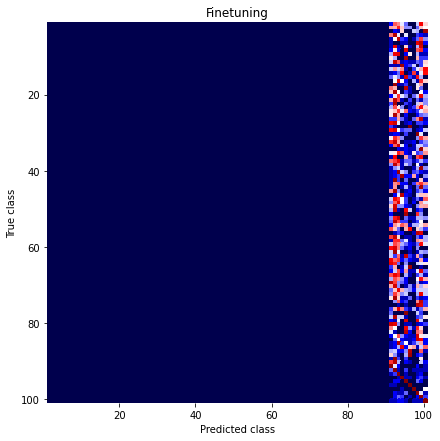

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = np.log(cm+1)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
ax.set_xticks(np.linspace(19,99,5))
ax.set_yticks(np.linspace(19,99,5))
ax.set_xticklabels([20,40,60,80,100], rotation=0)
ax.set_yticklabels([20,40,60,80,100], rotation=0)
ax.set_title("Finetuning")
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.savefig("Finetuning_"+str(randomseed)+"_cm.png")
plt.show()

with open('Finetuning_'+str(randomseed)+"_cm", 'wb') as file:
  pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)